In [1]:
import os
import pandas as pd
import numpy as np
import random
import shutil

# Organize Data

In [ ]:
assert False

data_url = "./Data/VGG Data/DATA"
train_url = "./Data/VGG Data/Train"
test_url = "./Data/VGG Data/Test"

test_size = 0.2

for class_label in os.listdir(data_url):
    images = os.listdir(f"{data_url}/{class_label}")
    random.shuffle(images)
    split_index = int(len(images) * test_size)
    
    for image in images[:split_index]:
        class_url = f"{test_url}/{str(class_label)}"

        if not os.path.exists(class_url):
            os.mkdir(class_url)
    
        old_image_url = f"{data_url}/{class_label}/{image}"
        new_image_url = f"{test_url}/{class_label}/{image}"
        shutil.move(old_image_url, new_image_url)
        
    for image in images[split_index:]:
        class_url = f"{train_url}/{str(class_label)}"

        if not os.path.exists(class_url):
            os.mkdir(class_url)
    
        old_image_url = f"{data_url}/{class_label}/{image}"
        new_image_url = f"{train_url}/{class_label}/{image}"
        shutil.move(old_image_url, new_image_url)

In [2]:
label_URL = "./Data/labels.csv"

labels = pd.read_csv(label_URL)
print(labels.shape)
labels.head()

(58, 2)


,ClassId,Name
0,0,Speed limit (5km/h)
1,1,Speed limit (15km/h)
2,2,Speed limit (30km/h)
3,3,Speed limit (40km/h)
4,4,Speed limit (50km/h)


In [ ]:
test_URL = "./Data/Test/"

sizes = set()

for class_label in os.listdir(test_URL):
    if not os.path.isdir(test_URL + class_label):
        continue
    for image in os.listdir(test_URL + class_label):
        sizes.add(Image.open(test_URL + class_label + "/" + image).size)
print(sizes)

# Models
## VGG16

In [13]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout

target_size = (128, 128)
num_classes = 58

In [14]:
feature_layers = [
    Conv2D(input_shape=(128,128,3), filters=64, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2), strides=(2,2)),
    
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2), strides=(2,2)),
    
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2), strides=(2,2)),
    
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2), strides=(2,2)),
    
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2), strides=(2,2)),
]

classifier_layers = [
    Flatten(),
    Dense(units=4096, activation="relu"),
    Dropout(0.5),
    Dense(units=4096, activation="relu"),
    Dropout(0.5),
    Dense(units=num_classes, activation="softmax"),
]

In [15]:
vgg16 = Sequential()

for layer in feature_layers:
    vgg16.add(layer)
    
vgg16.load_weights("./Pretrained Models/VGG16.h5")

for layer in classifier_layers:
    vgg16.add(layer)

for layer in vgg16.layers[:-3]:
    layer.trainable=False
    
vgg16.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 128, 128, 64)      1792      
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 128)      0         
 2D)                                                  

## ResNet50

In [149]:
num_classes = 58
resnet50_pretrained_weights_url = "./Pretrained Models/ResNet50.h5"

In [150]:
import torch.nn as nn

class Bottleneck(nn.Module):
    def __init__(self, channel_in, channel_mid, channel_out, padding=1, stride=1, downsample=None):
        super().__init__()
        
        self.conv1 = nn.Conv2d(channel_in, channel_mid, kernel_size=(1, 1), bias=False)
        self.bn1 = nn.BatchNorm2d(channel_mid)
        self.conv2 = nn.Conv2d(channel_mid, channel_mid, kernel_size=(3, 3), stride=stride, padding=padding, bias=False)
        self.bn2 = nn.BatchNorm2d(channel_mid)
        self.conv3 = nn.Conv2d(channel_mid, channel_out, kernel_size=(1, 1), bias=False)
        self.bn3 = nn.BatchNorm2d(channel_out)
        self.relu = nn.ReLU(inplace=True)
        
        self.downsample = downsample
        
    def forward(self, x):
        residual = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        out = self.conv3(out)
        out = self.bn3(out)
        
        if self.downsample:
            residual = self.downsample(residual)
            
        out += residual
        out = self.relu(out)
        
        return out

class ResNet50(nn.Module):
    def __init__(self):
        super(ResNet50, self).__init__()
        self.conv1 =  nn.Conv2d(3, 64, kernel_size=(7, 7), stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self.make_layer(64, 64, 256, 3)
        self.layer2 = self.make_layer(256, 128, 512, 4, stride=2)
        self.layer3 = self.make_layer(512, 256, 1024, 6, stride=2)
        self.layer4 = self.make_layer(1024, 512, 2048, 3, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, 1000)
        
    def make_layer(self, channel_in, channel_mid, channel_out, num_blocks, stride=1):
        downsample = nn.Sequential(
            nn.Conv2d(channel_in, channel_out, kernel_size=(1, 1), stride=stride, bias=False),
            nn.BatchNorm2d(channel_out)
        )
        layers = [
            Bottleneck(channel_in, channel_mid, channel_out, stride=stride, downsample=downsample)
        ]
        for _ in range(1, num_blocks):
            layers.append(
                Bottleneck(channel_out, channel_mid, channel_out)
            )
        return nn.Sequential(*layers)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        
        return out

In [173]:
from torchsummary import summary

resnet50 = ResNet50()

resnet50.load_state_dict(torch.load(resnet50_pretrained_weights_url))

for param in resnet50.parameters():
    param.requires_grad = False
    
resnet50.fc = nn.Linear(2048, num_classes)
    
summary(resnet50.to("cuda"), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
           Conv2d-10            [-1, 256, 8, 8]          16,384
      BatchNorm2d-11            [-1, 256, 8, 8]             512
           Conv2d-12            [-1, 256, 8, 8]          16,384
      BatchNorm2d-13            [-1, 256, 8, 8]             512
             ReLU-14            [-1, 25

## LeNet5

In [4]:
import cv2 as cv
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, AveragePooling2D, Dropout, BatchNormalization

num_classes = 58
target_size = (32, 32)

In [5]:
lenet5 = Sequential([   
    Conv2D(filters=6, input_shape=(32, 32, 1), kernel_size=(5, 5), activation="tanh"),
    BatchNormalization(),
    AveragePooling2D(2),
    Conv2D(filters=16, kernel_size=(5, 5), activation="tanh"),
    BatchNormalization(),
    AveragePooling2D(2),
    Conv2D(filters=120, kernel_size=(5, 5), activation="tanh"),
    Flatten(),
    Dense(84, activation='tanh'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax'),
])
    
lenet5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 6)        24        
 ormalization)                                                   
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 batch_normalization_1 (Batc  (None, 10, 10, 16)       64        
 hNormalization)                                                 
                                                        

# Training
## VGG16

In [1]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input

In [2]:
train_url = "./Data/VGG Data/Train"
test_url = "./Data/VGG Data/Test"
batch_size = 64
target_size = (128, 128)

train_batches = ImageDataGenerator(horizontal_flip=True, 
    vertical_flip=True,
    rotation_range=15,  fill_mode='nearest',
    preprocessing_function=preprocess_input) \
    .flow_from_directory(train_url, shuffle=True, class_mode="categorical", batch_size=batch_size, target_size=target_size)

test_batches = ImageDataGenerator(preprocessing_function=preprocess_input) \
    .flow_from_directory(test_url, shuffle=True, class_mode="categorical", batch_size=batch_size, target_size=target_size)

Found 3352 images belonging to 58 classes.
Found 818 images belonging to 58 classes.


In [16]:
vgg16.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = vgg16.fit(
    train_batches,
    epochs=25,
    verbose=2,`
    validation_data=test_batches
)

Epoch 1/25
53/53 - 133s - loss: 18.4958 - accuracy: 0.4236 - val_loss: 1.5551 - val_accuracy: 0.7262 - 133s/epoch - 3s/step
Epoch 2/25
53/53 - 132s - loss: 1.8073 - accuracy: 0.6498 - val_loss: 0.8828 - val_accuracy: 0.7787 - 132s/epoch - 2s/step
Epoch 3/25
53/53 - 131s - loss: 1.2763 - accuracy: 0.6972 - val_loss: 0.7509 - val_accuracy: 0.8117 - 131s/epoch - 2s/step
Epoch 4/25
53/53 - 131s - loss: 1.0497 - accuracy: 0.7366 - val_loss: 0.6338 - val_accuracy: 0.8496 - 131s/epoch - 2s/step
Epoch 5/25
53/53 - 141s - loss: 0.9656 - accuracy: 0.7506 - val_loss: 0.4957 - val_accuracy: 0.8557 - 141s/epoch - 3s/step
Epoch 6/25
53/53 - 124s - loss: 0.8769 - accuracy: 0.7601 - val_loss: 0.4763 - val_accuracy: 0.8802 - 124s/epoch - 2s/step
Epoch 7/25
53/53 - 120s - loss: 0.8707 - accuracy: 0.7643 - val_loss: 0.5176 - val_accuracy: 0.8594 - 120s/epoch - 2s/step
Epoch 8/25
53/53 - 122s - loss: 0.8082 - accuracy: 0.7861 - val_loss: 0.4336 - val_accuracy: 0.8875 - 122s/epoch - 2s/step
Epoch 9/25
53/5

In [17]:
print(history.history)

{'loss': [18.495786666870117, 1.807276725769043, 1.2762949466705322, 1.049725890159607, 0.9655517935752869, 0.8768996596336365, 0.8707289099693298, 0.8082437515258789, 0.7173795700073242, 0.6627148985862732, 0.6211662888526917, 0.6061546206474304, 0.6576218605041504, 0.5842801332473755, 0.5157001614570618, 0.6151339411735535, 0.6180315613746643, 0.5887635350227356, 0.5786851644515991, 0.5693687796592712, 0.5780088305473328, 0.5755603313446045, 0.5598148107528687, 0.611248254776001, 0.5443534851074219], 'accuracy': [0.42362767457962036, 0.6497613191604614, 0.6971957087516785, 0.736575186252594, 0.7505966424942017, 0.7601432204246521, 0.7643198370933533, 0.7860978245735168, 0.8081742525100708, 0.8159307837486267, 0.8299522399902344, 0.8278639912605286, 0.8245823383331299, 0.8394988179206848, 0.8454654216766357, 0.834725558757782, 0.8308472633361816, 0.8406921029090881, 0.8463603854179382, 0.8505370020866394, 0.8517302870750427, 0.8568019270896912, 0.8547136187553406, 0.8418854475021362, 

In [ ]:
# No Pretrain
'''
{'loss': [3.525979995727539, 2.8899519443511963, 2.434882879257202, 2.1614224910736084, 1.9181642532348633, 1.7425360679626465, 1.5772042274475098, 1.4680629968643188, 1.3730199337005615, 1.2916934490203857, 1.1915274858474731, 1.1220812797546387, 1.0652923583984375, 1.0273462533950806, 0.9893081188201904, 0.9514791369438171, 0.9155832529067993, 0.8515679836273193, 0.8318435549736023, 0.7995812296867371, 0.7598579525947571, 0.7885639667510986, 0.7145692110061646, 0.6884155869483948, 0.6722703576087952], 'accuracy': [0.16557279229164124, 0.2849045395851135, 0.38007161021232605, 0.4239260256290436, 0.48359188437461853, 0.5280429720878601, 0.5638424754142761, 0.5883054733276367, 0.6172434091567993, 0.6360381841659546, 0.6587111949920654, 0.6784009337425232, 0.6837708950042725, 0.7010740041732788, 0.7058472633361816, 0.7177804112434387, 0.7228520512580872, 0.745525062084198, 0.7505966424942017, 0.7619331479072571, 0.7661097645759583, 0.7583532333374023, 0.7822195887565613, 0.7941527366638184, 0.7986276745796204], 'val_loss': [3.0600991249084473, 2.505634307861328, 2.191805839538574, 1.9498416185379028, 1.6910334825515747, 1.4788415431976318, 1.4141517877578735, 1.2690953016281128, 1.189495325088501, 1.0745114088058472, 1.0205894708633423, 0.9052702784538269, 0.884761393070221, 0.8621788620948792, 0.8151814341545105, 0.7674565315246582, 0.7320774793624878, 0.7032402157783508, 0.6263027787208557, 0.6146522164344788, 0.5949746370315552, 0.5954749584197998, 0.5730560421943665, 0.5685215592384338, 0.5240790247917175], 'val_accuracy': [0.3361858129501343, 0.43276283144950867, 0.4682151675224304, 0.48655256628990173, 0.5586796998977661, 0.6185818910598755, 0.6234718561172485, 0.6772615909576416, 0.7127139568328857, 0.738386332988739, 0.7359412908554077, 0.761613667011261, 0.790953516960144, 0.7836185693740845, 0.7762836217880249, 0.7958435416221619, 0.8117359280586243, 0.8239609003067017, 0.8484107851982117, 0.8361858129501343, 0.8569682240486145, 0.8557457327842712, 0.8728606104850769, 0.8667481541633606, 0.8765281438827515]}
'''
# Pretrain
'''
{'loss': [18.793527603149414, 1.252179741859436, 0.7609100937843323, 0.5249869227409363, 0.44329315423965454, 0.40843403339385986, 0.3812047839164734, 0.4069596827030182, 0.37956562638282776, 0.4497087001800537, 0.42380839586257935, 0.48469915986061096, 0.5351912379264832, 0.4932202100753784, 0.48433583974838257, 0.4134829342365265, 0.39266371726989746, 0.40559425950050354, 0.34826433658599854, 0.3698195517063141, 0.3830086290836334, 0.3082433342933655, 0.3518733084201813, 0.4435766041278839, 0.3689365088939667], 'accuracy': [0.546241044998169, 0.8505370020866394, 0.8758949637413025, 0.906324565410614, 0.9191527366638184, 0.9266110062599182, 0.9328758716583252, 0.9284009337425232, 0.943615734577179, 0.9316825866699219, 0.9364558458328247, 0.9295942783355713, 0.9373508095741272, 0.9406324625015259, 0.9415274262428284, 0.9486873745918274, 0.9504773020744324, 0.9555489420890808, 0.9603222012519836, 0.952565610408783, 0.9543555974960327, 0.9576372504234314, 0.9567422270774841, 0.9501789808273315, 0.9606205224990845], 'val_loss': [1.1364144086837769, 0.5852822065353394, 0.46912509202957153, 0.3824549913406372, 0.4593915641307831, 0.4409973621368408, 0.37583020329475403, 0.3581882417201996, 0.622353732585907, 0.37841796875, 0.3754598796367645, 0.4300534129142761, 0.5109768509864807, 0.37367919087409973, 0.37530601024627686, 0.6197020411491394, 0.3931267559528351, 0.5752502083778381, 0.6990096569061279, 0.40637508034706116, 0.39942750334739685, 0.6513607501983643, 0.5577841997146606, 0.6005098223686218, 0.5296468734741211], 'val_accuracy': [0.8814181089401245, 0.9107579588890076, 0.9449877738952637, 0.9572126865386963, 0.9498777389526367, 0.9486552476882935, 0.9669926762580872, 0.9706601500511169, 0.9376528263092041, 0.9731051325798035, 0.9645476937294006, 0.9621027112007141, 0.9547677040100098, 0.9657701849937439, 0.9731051325798035, 0.9547677040100098, 0.9706601500511169, 0.9718826413154602, 0.9657701849937439, 0.9743276238441467, 0.9779950976371765, 0.9706601500511169, 0.9767726063728333, 0.97555011510849, 0.97555011510849]}
'''

## Resnet50

In [176]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms

train_url = "./Data/VGG Data/Train"
test_url = "./Data/VGG Data/Test"
batch_size = 50
num_classes = 58
target_size = (32, 32)

resize = transforms.Resize(size=target_size)
horizontal_flip = transforms.RandomHorizontalFlip(p=0.25)
vertical_flip = transforms.RandomVerticalFlip(p=0.25)
rotate = transforms.RandomRotation(degrees=15)

train_transforms = transforms.Compose([resize, horizontal_flip, vertical_flip, rotate, transforms.ToTensor()])
test_transforms = transforms.Compose([resize, transforms.ToTensor()])

train_data = ImageFolder(root=train_url, transform=train_transforms)
test_data = ImageFolder(root=test_url, transform=test_transforms)

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

print(f"Found {len(train_dataloader.dataset)} Training Images for {len(train_data.classes)} classes")
print(f"Found {len(test_dataloader.dataset)} Test Images for {len(test_data.classes)} classes")

Found 3352 Training Images for 58 classes
Found 818 Test Images for 58 classes


In [183]:
import torch
from torch.nn import CrossEntropyLoss
import torch.optim as optim

criterion = CrossEntropyLoss()
optimizer = optim.Adam(resnet50.parameters(), lr=0.001)

use_gpu = True

if use_gpu and torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using GPU")
else:
    device = torch.device('cpu')
    print("Using CPU")

Using GPU


In [184]:
from torch.autograd import Variable

epochs = 25

history = {
    "loss": [],
    "val_loss": [],
    "accuracy": [],
    "val_accuracy": []
}

resnet50 = resnet50.to(device=device)  # move the model parameters to CPU/GPU
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    
    loss_train = 0
    accuracy_train = 0
    samples_train = 0
    
    resnet50.train(True)
    for _, (inputs, labels) in enumerate(train_dataloader):
        optimizer.zero_grad()
        
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
                
        scores = resnet50(inputs)
        _, predictions = torch.max(scores.data, 1)
        loss = criterion(scores, labels)

        loss.backward()
        optimizer.step()
        
        accuracy_train += torch.sum(predictions == labels.data).item()
        loss_train += loss.item()
        samples_train += predictions.size(0)

        del inputs, labels, scores, predictions
        torch.cuda.empty_cache()
        
    history["loss"].append(loss_train / len(train_dataloader.dataset))
    history["accuracy"].append(accuracy_train / samples_train)
    
    resnet50.train(False)
    resnet50.eval()
        
    loss_validation = 0
    accuracy_validation = 0
    samples_validation = 0
    
    for _, (inputs, labels) in enumerate(test_dataloader):
        optimizer.zero_grad()
        
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
                
        scores = resnet50(inputs)
        _, predictions = torch.max(scores.data, 1)
        loss = criterion(scores, labels)
        
        accuracy_validation += torch.sum(predictions == labels.data).item()
        loss_validation += loss.item()
        samples_validation += predictions.size(0)

        del inputs, labels, scores, predictions
        torch.cuda.empty_cache()
    
    history["val_loss"].append(loss_validation / len(train_dataloader.dataset))
    history["val_accuracy"].append(accuracy_validation / samples_validation)
    
    print(f'Training Loss: {round(history["loss"][-1], 4)}', end=" - ")
    print(f'Training Accuracy: {round(history["accuracy"][-1], 4)}', end=" - ")
    print(f'Validation Loss: {round(history["val_loss"][-1], 4)}', end=" - ")
    print(f'Validation Accuracy: {round(history["val_accuracy"][-1], 4)}')
    print("===================================================")

Epoch 1/25
Training Loss: 0.0095 - Training Accuracy: 0.8517 - Validation Loss: 0.0018 - Validation Accuracy: 0.9108
Epoch 2/25
Training Loss: 0.0098 - Training Accuracy: 0.8842 - Validation Loss: 0.0019 - Validation Accuracy: 0.8998
Epoch 3/25
Training Loss: 0.0081 - Training Accuracy: 0.8828 - Validation Loss: 0.002 - Validation Accuracy: 0.8851
Epoch 4/25
Training Loss: 0.013 - Training Accuracy: 0.8159 - Validation Loss: 0.0027 - Validation Accuracy: 0.8533
Epoch 5/25
Training Loss: 0.0101 - Training Accuracy: 0.8652 - Validation Loss: 0.0017 - Validation Accuracy: 0.9169
Epoch 6/25
Training Loss: 0.0095 - Training Accuracy: 0.8768 - Validation Loss: 0.0017 - Validation Accuracy: 0.901
Epoch 7/25
Training Loss: 0.0099 - Training Accuracy: 0.8953 - Validation Loss: 0.0014 - Validation Accuracy: 0.9254
Epoch 8/25
Training Loss: 0.0085 - Training Accuracy: 0.8881 - Validation Loss: 0.0015 - Validation Accuracy: 0.9279
Epoch 9/25
Training Loss: 0.007 - Training Accuracy: 0.901 - Valida

In [185]:
print(history)

{'loss': [0.009493214173824805, 0.00983126290355918, 0.008130615021419981, 0.012979819935019659, 0.010140858617275598, 0.009539357535452148, 0.009867148829495138, 0.008546154083670751, 0.007014034807166365, 0.008028702657038528, 0.007714278266936327, 0.007679224129864026, 0.006335351269398782, 0.007056952609740607, 0.006053256963408577, 0.005443607238043535, 0.0064039000472262825, 0.005109014563031299, 0.006110850050334145, 0.007264184405435952, 0.006139210030783261, 0.005097257160094871, 0.004508701874374419, 0.0061953639342651875, 0.0050844423792953996], 'val_loss': [0.0018351973303391428, 0.0018531250187278079, 0.0019847011118060364, 0.0027013684051702585, 0.0016516506991978192, 0.001671742243349979, 0.0013728741409706046, 0.0014951299200265675, 0.0020366127609424203, 0.00147638477491735, 0.0016153565294560498, 0.0011558304863108371, 0.0029085180355427087, 0.0017747345596089569, 0.04098406808366355, 0.004142743499776202, 0.0018262280671366075, 0.0013849389359248281, 0.00134439431108

In [ ]:
'''
{'loss': [0.009493214173824805, 0.00983126290355918, 0.008130615021419981, 0.012979819935019659, 0.010140858617275598, 0.009539357535452148, 0.009867148829495138, 0.008546154083670751, 0.007014034807166365, 0.008028702657038528, 0.007714278266936327, 0.007679224129864026, 0.006335351269398782, 0.007056952609740607, 0.006053256963408577, 0.005443607238043535, 0.0064039000472262825, 0.005109014563031299, 0.006110850050334145, 0.007264184405435952, 0.006139210030783261, 0.005097257160094871, 0.004508701874374419, 0.0061953639342651875, 0.0050844423792953996], 'val_loss': [0.0018351973303391428, 0.0018531250187278079, 0.0019847011118060364, 0.0027013684051702585, 0.0016516506991978192, 0.001671742243349979, 0.0013728741409706046, 0.0014951299200265675, 0.0020366127609424203, 0.00147638477491735, 0.0016153565294560498, 0.0011558304863108371, 0.0029085180355427087, 0.0017747345596089569, 0.04098406808366355, 0.004142743499776202, 0.0018262280671366075, 0.0013849389359248281, 0.0013443943110865882, 0.0012713207547644016, 0.0013210206417042345, 0.0013177941657762824, 0.001162755140825786, 0.0015823986661355934, 0.0016001169180813153], 'accuracy': [0.8517303102625299, 0.8842482100238663, 0.8827565632458234, 0.8159307875894988, 0.8651551312649165, 0.8767899761336515, 0.8952863961813843, 0.888126491646778, 0.9009546539379475, 0.9090095465393795, 0.9084128878281623, 0.9099045346062052, 0.912291169451074, 0.9099045346062052, 0.9134844868735084, 0.915871121718377, 0.920346062052506, 0.9242243436754176, 0.918854415274463, 0.9140811455847255, 0.9248210023866349, 0.9278042959427207, 0.9334725536992841, 0.9292959427207638, 0.9325775656324582], 'val_accuracy': [0.910757946210269, 0.8997555012224939, 0.8850855745721271, 0.8533007334963325, 0.9168704156479217, 0.9009779951100244, 0.9254278728606357, 0.9278728606356969, 0.9254278728606357, 0.9242053789731052, 0.910757946210269, 0.941320293398533, 0.9254278728606357, 0.9388753056234719, 0.8887530562347188, 0.9254278728606357, 0.8985330073349633, 0.9315403422982885, 0.9339853300733496, 0.9425427872860636, 0.9303178484107579, 0.941320293398533, 0.9425427872860636, 0.9242053789731052, 0.9180929095354523]}
'''

## LeNet5

In [6]:
from keras.preprocessing.image import ImageDataGenerator

train_url = "./Data/VGG Data/Train"
test_url = "./Data/VGG Data/Test"
batch_size = 50
num_classes = 58
target_size = (32, 32)

train_batches = ImageDataGenerator(
    horizontal_flip=True, 
    vertical_flip=True,
    rotation_range=15,  fill_mode='nearest',
    rescale = 1./255.) \
    .flow_from_directory(train_url, target_size=target_size, color_mode="grayscale")

test_batches = ImageDataGenerator(rescale = 1./255.).flow_from_directory(test_url, target_size=target_size, color_mode="grayscale")

Found 3352 images belonging to 58 classes.
Found 818 images belonging to 58 classes.


In [7]:
lenet5.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = lenet5.fit(
    train_batches,
    epochs=25,
    verbose=2,
    validation_data=test_batches,
)

Epoch 1/25
105/105 - 95s - loss: 2.8841 - accuracy: 0.2903 - val_loss: 3.1512 - val_accuracy: 0.3582 - 95s/epoch - 904ms/step
Epoch 2/25
105/105 - 5s - loss: 2.0809 - accuracy: 0.4526 - val_loss: 2.3059 - val_accuracy: 0.3606 - 5s/epoch - 51ms/step
Epoch 3/25
105/105 - 5s - loss: 1.7401 - accuracy: 0.5337 - val_loss: 2.4140 - val_accuracy: 0.3105 - 5s/epoch - 50ms/step
Epoch 4/25
105/105 - 5s - loss: 1.5244 - accuracy: 0.5817 - val_loss: 3.1590 - val_accuracy: 0.1968 - 5s/epoch - 50ms/step
Epoch 5/25
105/105 - 5s - loss: 1.3470 - accuracy: 0.6265 - val_loss: 1.7599 - val_accuracy: 0.4780 - 5s/epoch - 50ms/step
Epoch 6/25
105/105 - 5s - loss: 1.2252 - accuracy: 0.6605 - val_loss: 1.4084 - val_accuracy: 0.5966 - 5s/epoch - 50ms/step
Epoch 7/25
105/105 - 5s - loss: 1.1006 - accuracy: 0.6918 - val_loss: 1.2037 - val_accuracy: 0.6675 - 5s/epoch - 50ms/step
Epoch 8/25
105/105 - 5s - loss: 0.9996 - accuracy: 0.7208 - val_loss: 1.1746 - val_accuracy: 0.6638 - 5s/epoch - 51ms/step
Epoch 9/25
10

In [8]:
print(history.history)

{'loss': [2.8840887546539307, 2.0809338092803955, 1.7401418685913086, 1.5243587493896484, 1.3469784259796143, 1.225151538848877, 1.1006319522857666, 0.9996498823165894, 0.9391777515411377, 0.8557184338569641, 0.8089783787727356, 0.7434625625610352, 0.6987015604972839, 0.643904447555542, 0.6064826250076294, 0.583538293838501, 0.5438234210014343, 0.52963787317276, 0.48795536160469055, 0.4657800793647766, 0.4647940993309021, 0.425964891910553, 0.40210771560668945, 0.3917861580848694, 0.39241230487823486], 'accuracy': [0.2902744710445404, 0.45256564021110535, 0.5337111949920654, 0.5817422270774841, 0.6264916658401489, 0.6605011820793152, 0.6918257474899292, 0.7207637429237366, 0.7413484454154968, 0.7520883083343506, 0.776849627494812, 0.7863962054252625, 0.805190920829773, 0.8189140558242798, 0.8278639912605286, 0.828758955001831, 0.8469570279121399, 0.8544152975082397, 0.8624701499938965, 0.8657518029212952, 0.8651551604270935, 0.8788782954216003, 0.8830549120903015, 0.8866348266601562, 0

In [30]:
lenet5.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = lenet5.fit(
    train_batches,
    epochs=25,
    verbose=2,
    validation_data=test_batches,
)

Epoch 1/25
105/105 - 92s - loss: 2.4090 - accuracy: 0.4576 - val_loss: 2.8921 - val_accuracy: 0.3802 - 92s/epoch - 871ms/step
Epoch 2/25
105/105 - 5s - loss: 1.2470 - accuracy: 0.7005 - val_loss: 2.0968 - val_accuracy: 0.4315 - 5s/epoch - 45ms/step
Epoch 3/25
105/105 - 5s - loss: 0.8501 - accuracy: 0.7974 - val_loss: 1.0611 - val_accuracy: 0.7298 - 5s/epoch - 46ms/step
Epoch 4/25
105/105 - 5s - loss: 0.6194 - accuracy: 0.8538 - val_loss: 0.7266 - val_accuracy: 0.8142 - 5s/epoch - 46ms/step
Epoch 5/25
105/105 - 5s - loss: 0.4766 - accuracy: 0.9024 - val_loss: 0.4380 - val_accuracy: 0.9095 - 5s/epoch - 46ms/step
Epoch 6/25
105/105 - 5s - loss: 0.3633 - accuracy: 0.9284 - val_loss: 0.3592 - val_accuracy: 0.9144 - 5s/epoch - 46ms/step
Epoch 7/25
105/105 - 5s - loss: 0.2995 - accuracy: 0.9466 - val_loss: 0.2512 - val_accuracy: 0.9487 - 5s/epoch - 46ms/step
Epoch 8/25
105/105 - 5s - loss: 0.2286 - accuracy: 0.9555 - val_loss: 0.2037 - val_accuracy: 0.9621 - 5s/epoch - 46ms/step
Epoch 9/25
10

In [31]:
print(history.history)

{'loss': [2.4090163707733154, 1.246998906135559, 0.8500944375991821, 0.6194496750831604, 0.4766201376914978, 0.36325007677078247, 0.29954662919044495, 0.22860822081565857, 0.19289346039295197, 0.15308305621147156, 0.12921340763568878, 0.10714416950941086, 0.08924271166324615, 0.07938934117555618, 0.06297250092029572, 0.057640984654426575, 0.04943648353219032, 0.042869050055742264, 0.037212107330560684, 0.031125769019126892, 0.027826787903904915, 0.025495674461126328, 0.020977916195988655, 0.020899269729852676, 0.018425533547997475], 'accuracy': [0.457637220621109, 0.7004773020744324, 0.797434389591217, 0.8538185954093933, 0.9024463295936584, 0.9284009337425232, 0.9465990662574768, 0.9555489420890808, 0.9644988179206848, 0.9740453362464905, 0.9785202741622925, 0.9847851991653442, 0.9883651733398438, 0.9901551604270935, 0.9931384325027466, 0.9925417900085449, 0.9958233833312988, 0.9976133704185486, 0.9967184066772461, 0.9973150491714478, 0.9988066554069519, 0.9985083341598511, 0.99821001

In [ ]:
# Final
'''
{'loss': [2.4090163707733154, 1.246998906135559, 0.8500944375991821, 0.6194496750831604, 0.4766201376914978, 0.36325007677078247, 0.29954662919044495, 0.22860822081565857, 0.19289346039295197, 0.15308305621147156, 0.12921340763568878, 0.10714416950941086, 0.08924271166324615, 0.07938934117555618, 0.06297250092029572, 0.057640984654426575, 0.04943648353219032, 0.042869050055742264, 0.037212107330560684, 0.031125769019126892, 0.027826787903904915, 0.025495674461126328, 0.020977916195988655, 0.020899269729852676, 0.018425533547997475], 'accuracy': [0.457637220621109, 0.7004773020744324, 0.797434389591217, 0.8538185954093933, 0.9024463295936584, 0.9284009337425232, 0.9465990662574768, 0.9555489420890808, 0.9644988179206848, 0.9740453362464905, 0.9785202741622925, 0.9847851991653442, 0.9883651733398438, 0.9901551604270935, 0.9931384325027466, 0.9925417900085449, 0.9958233833312988, 0.9976133704185486, 0.9967184066772461, 0.9973150491714478, 0.9988066554069519, 0.9985083341598511, 0.9982100129127502, 0.9991050362586975, 0.9988066554069519], 'val_loss': [2.892059803009033, 2.0967772006988525, 1.0611306428909302, 0.7265735268592834, 0.4380408227443695, 0.3591668903827667, 0.25116413831710815, 0.2036823183298111, 0.17422233521938324, 0.1465422511100769, 0.1296873241662979, 0.11422838270664215, 0.10367361456155777, 0.09712772071361542, 0.08032127469778061, 0.07639740407466888, 0.07686100900173187, 0.06060873717069626, 0.062211472541093826, 0.06978555023670197, 0.064402274787426, 0.05597684904932976, 0.05702206492424011, 0.053716663271188736, 0.0548069030046463], 'val_accuracy': [0.38019558787345886, 0.4315403401851654, 0.7298288345336914, 0.8141809105873108, 0.9095354676246643, 0.9144254326820374, 0.9486552476882935, 0.9621027112007141, 0.9621027112007141, 0.97555011510849, 0.9731051325798035, 0.980440080165863, 0.97555011510849, 0.9779950976371765, 0.9865525960922241, 0.9816625714302063, 0.9828850626945496, 0.9889975786209106, 0.9853300452232361, 0.980440080165863, 0.9877750873565674, 0.9853300452232361, 0.9828850626945496, 0.9828850626945496, 0.9877750873565674]}
'''

# Preprocessing Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


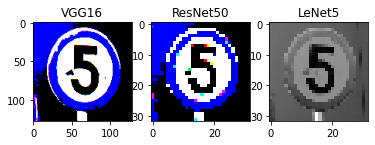

In [37]:
import keras
from keras.utils import load_img, img_to_array
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


image_url = "./Data/VGG Data/Train/0/000_0001.png"

image_vgg = load_img(image_url, target_size=(128, 128))
image_resnet = load_img(image_url, target_size=(32, 32))
image_lenet = load_img(image_url, color_mode='grayscale', target_size=(32, 32))

imgage_vgg = img_to_array(image_vgg)
image_resnet = img_to_array(image_resnet)
image_lenet = img_to_array(image_lenet)

image_vgg = np.expand_dims(image_vgg, axis=0)
image_resnet = np.expand_dims(image_resnet, axis=0)
image_lenet = np.expand_dims(image_lenet, axis=0)

image_lenet /= 255

image_vgg = keras.applications.vgg16.preprocess_input(image_vgg)
image_resnet = tf.keras.applications.resnet50.preprocess_input(image_resnet)

fig, axes = plt.subplots(1, 3, figsize=(6,6))

axes[0].imshow(image_vgg[0])
axes[0].set_title("VGG16")

axes[1].imshow(image_resnet[0])
axes[1].set_title("ResNet50")

axes[2].imshow(image_lenet[0], cmap='gray',)
axes[2].set_title("LeNet5")

plt.show()

# Training Visualization

In [38]:
lenet5_history = {'loss': [2.4090163707733154, 1.246998906135559, 0.8500944375991821, 0.6194496750831604, 0.4766201376914978, 0.36325007677078247, 0.29954662919044495, 0.22860822081565857, 0.19289346039295197, 0.15308305621147156, 0.12921340763568878, 0.10714416950941086, 0.08924271166324615, 0.07938934117555618, 0.06297250092029572, 0.057640984654426575, 0.04943648353219032, 0.042869050055742264, 0.037212107330560684, 0.031125769019126892, 0.027826787903904915, 0.025495674461126328, 0.020977916195988655, 0.020899269729852676, 0.018425533547997475], 'accuracy': [0.457637220621109, 0.7004773020744324, 0.797434389591217, 0.8538185954093933, 0.9024463295936584, 0.9284009337425232, 0.9465990662574768, 0.9555489420890808, 0.9644988179206848, 0.9740453362464905, 0.9785202741622925, 0.9847851991653442, 0.9883651733398438, 0.9901551604270935, 0.9931384325027466, 0.9925417900085449, 0.9958233833312988, 0.9976133704185486, 0.9967184066772461, 0.9973150491714478, 0.9988066554069519, 0.9985083341598511, 0.9982100129127502, 0.9991050362586975, 0.9988066554069519], 'val_loss': [2.892059803009033, 2.0967772006988525, 1.0611306428909302, 0.7265735268592834, 0.4380408227443695, 0.3591668903827667, 0.25116413831710815, 0.2036823183298111, 0.17422233521938324, 0.1465422511100769, 0.1296873241662979, 0.11422838270664215, 0.10367361456155777, 0.09712772071361542, 0.08032127469778061, 0.07639740407466888, 0.07686100900173187, 0.06060873717069626, 0.062211472541093826, 0.06978555023670197, 0.064402274787426, 0.05597684904932976, 0.05702206492424011, 0.053716663271188736, 0.0548069030046463], 'val_accuracy': [0.38019558787345886, 0.4315403401851654, 0.7298288345336914, 0.8141809105873108, 0.9095354676246643, 0.9144254326820374, 0.9486552476882935, 0.9621027112007141, 0.9621027112007141, 0.97555011510849, 0.9731051325798035, 0.980440080165863, 0.97555011510849, 0.9779950976371765, 0.9865525960922241, 0.9816625714302063, 0.9828850626945496, 0.9889975786209106, 0.9853300452232361, 0.980440080165863, 0.9877750873565674, 0.9853300452232361, 0.9828850626945496, 0.9828850626945496, 0.9877750873565674]}

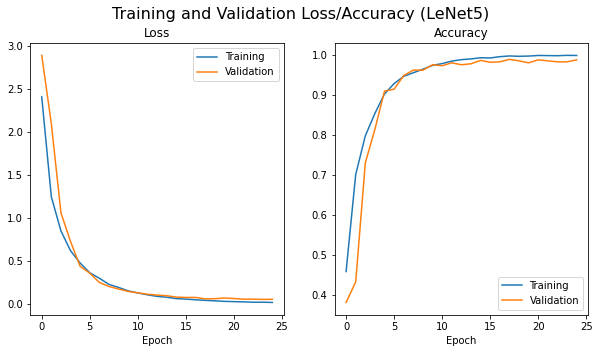

In [53]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

fig.suptitle("Training and Validation Loss/Accuracy (LeNet5)", fontsize=16)

axes[0].set_title("Loss")
axes[0].set_xlabel("Epoch")
axes[0].plot(lenet5_history["loss"], label='Training')
axes[0].plot(lenet5_history["val_loss"], label='Validation')
axes[0].legend()

axes[1].set_title("Accuracy")
axes[1].set_xlabel("Epoch")
axes[1].plot(lenet5_history["accuracy"], label='Training')
axes[1].plot(lenet5_history["val_accuracy"], label='Validation')
axes[1].legend()

plt.show()

In [51]:
resnet50_history = {'loss': [0.009493214173824805, 0.00983126290355918, 0.008130615021419981, 0.012979819935019659, 0.010140858617275598, 0.009539357535452148, 0.009867148829495138, 0.008546154083670751, 0.007014034807166365, 0.008028702657038528, 0.007714278266936327, 0.007679224129864026, 0.006335351269398782, 0.007056952609740607, 0.006053256963408577, 0.005443607238043535, 0.0064039000472262825, 0.005109014563031299, 0.006110850050334145, 0.007264184405435952, 0.006139210030783261, 0.005097257160094871, 0.004508701874374419, 0.0061953639342651875, 0.0050844423792953996], 'val_loss': [0.0018351973303391428, 0.0018531250187278079, 0.0019847011118060364, 0.0027013684051702585, 0.0016516506991978192, 0.001671742243349979, 0.0013728741409706046, 0.0014951299200265675, 0.0020366127609424203, 0.00147638477491735, 0.0016153565294560498, 0.0011558304863108371, 0.0029085180355427087, 0.0017747345596089569, 0.04098406808366355, 0.004142743499776202, 0.0018262280671366075, 0.0013849389359248281, 0.0013443943110865882, 0.0012713207547644016, 0.0013210206417042345, 0.0013177941657762824, 0.001162755140825786, 0.0015823986661355934, 0.0016001169180813153], 'accuracy': [0.8517303102625299, 0.8842482100238663, 0.8827565632458234, 0.8159307875894988, 0.8651551312649165, 0.8767899761336515, 0.8952863961813843, 0.888126491646778, 0.9009546539379475, 0.9090095465393795, 0.9084128878281623, 0.9099045346062052, 0.912291169451074, 0.9099045346062052, 0.9134844868735084, 0.915871121718377, 0.920346062052506, 0.9242243436754176, 0.918854415274463, 0.9140811455847255, 0.9248210023866349, 0.9278042959427207, 0.9334725536992841, 0.9292959427207638, 0.9325775656324582], 'val_accuracy': [0.910757946210269, 0.8997555012224939, 0.8850855745721271, 0.8533007334963325, 0.9168704156479217, 0.9009779951100244, 0.9254278728606357, 0.9278728606356969, 0.9254278728606357, 0.9242053789731052, 0.910757946210269, 0.941320293398533, 0.9254278728606357, 0.9388753056234719, 0.8887530562347188, 0.9254278728606357, 0.8985330073349633, 0.9315403422982885, 0.9339853300733496, 0.9425427872860636, 0.9303178484107579, 0.941320293398533, 0.9425427872860636, 0.9242053789731052, 0.9180929095354523]}

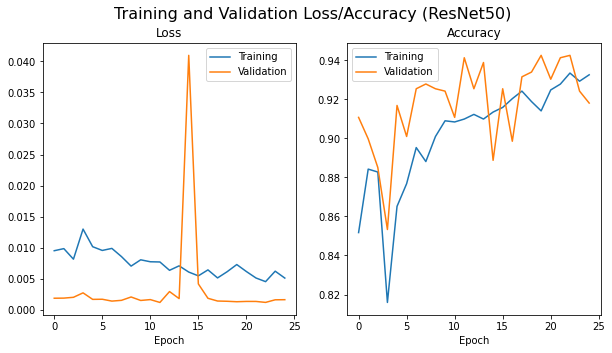

In [54]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

fig.suptitle("Training and Validation Loss/Accuracy (ResNet50)", fontsize=16)

axes[0].set_title("Loss")
axes[0].set_xlabel("Epoch")
axes[0].plot(resnet50_history["loss"], label='Training')
axes[0].plot(resnet50_history["val_loss"], label='Validation')
axes[0].legend()

axes[1].set_title("Accuracy")
axes[1].set_xlabel("Epoch")
axes[1].plot(resnet50_history["accuracy"], label='Training')
axes[1].plot(resnet50_history["val_accuracy"], label='Validation')
axes[1].legend()

plt.show()

In [55]:
vgg16_history = {'loss': [18.495786666870117, 1.807276725769043, 1.2762949466705322, 1.049725890159607, 0.9655517935752869, 0.8768996596336365, 0.8707289099693298, 0.8082437515258789, 0.7173795700073242, 0.6627148985862732, 0.6211662888526917, 0.6061546206474304, 0.6576218605041504, 0.5842801332473755, 0.5157001614570618, 0.6151339411735535, 0.6180315613746643, 0.5887635350227356, 0.5786851644515991, 0.5693687796592712, 0.5780088305473328, 0.5755603313446045, 0.5598148107528687, 0.611248254776001, 0.5443534851074219], 'accuracy': [0.42362767457962036, 0.6497613191604614, 0.6971957087516785, 0.736575186252594, 0.7505966424942017, 0.7601432204246521, 0.7643198370933533, 0.7860978245735168, 0.8081742525100708, 0.8159307837486267, 0.8299522399902344, 0.8278639912605286, 0.8245823383331299, 0.8394988179206848, 0.8454654216766357, 0.834725558757782, 0.8308472633361816, 0.8406921029090881, 0.8463603854179382, 0.8505370020866394, 0.8517302870750427, 0.8568019270896912, 0.8547136187553406, 0.8418854475021362, 0.8553102612495422], 'val_loss': [1.5551095008850098, 0.8828197121620178, 0.7509424090385437, 0.633762776851654, 0.49566423892974854, 0.4762522876262665, 0.5175999402999878, 0.43363285064697266, 0.33905351161956787, 0.3908633291721344, 0.3665279150009155, 0.3920276463031769, 0.4183062016963959, 0.3259461224079132, 0.35429561138153076, 0.30856430530548096, 0.30500462651252747, 0.24317333102226257, 0.31724002957344055, 0.3005700409412384, 0.28829652070999146, 0.3319234549999237, 0.3458017408847809, 0.279619425535202, 0.2157978117465973], 'val_accuracy': [0.7261613607406616, 0.7787286043167114, 0.8117359280586243, 0.8496332764625549, 0.8557457327842712, 0.8801956176757812, 0.859413206577301, 0.8875305652618408, 0.9119804501533508, 0.878973126411438, 0.9095354676246643, 0.8924205303192139, 0.9046455025672913, 0.9205378890037537, 0.9070904850959778, 0.9278728365898132, 0.9107579588890076, 0.9339853525161743, 0.9205378890037537, 0.9156479239463806, 0.9144254326820374, 0.9278728365898132, 0.9254278540611267, 0.9474327564239502, 0.9364303350448608]}

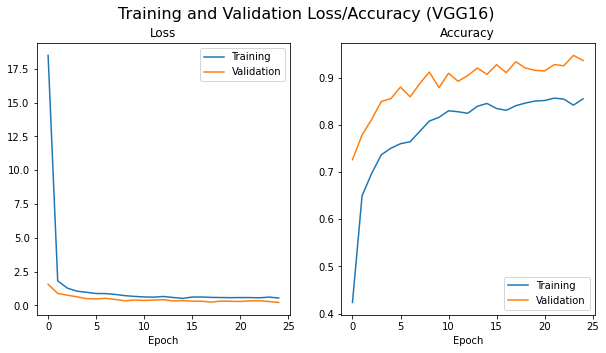

In [56]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

fig.suptitle("Training and Validation Loss/Accuracy (VGG16)", fontsize=16)

axes[0].set_title("Loss")
axes[0].set_xlabel("Epoch")
axes[0].plot(vgg16_history["loss"], label='Training')
axes[0].plot(vgg16_history["val_loss"], label='Validation')
axes[0].legend()

axes[1].set_title("Accuracy")
axes[1].set_xlabel("Epoch")
axes[1].plot(vgg16_history["accuracy"], label='Training')
axes[1].plot(vgg16_history["val_accuracy"], label='Validation')
axes[1].legend()

plt.show()